## Fake News Classifier with Program Optimization


In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.gridspec as gridspec

# For multiprocessing
from multiprocessing import Pool, cpu_count

# For timing comparison
performance_times = []
performance_methods = []
performance_accuracies = []

# For consistent color scheme
sns.set_theme(style="whitegrid")
colors = sns.color_palette("Set2")

def track_performance(method_name, execution_time, accuracy):
    """Track performance metrics for later visualization"""
    performance_methods.append(method_name)
    performance_times.append(execution_time)
    performance_accuracies.append(accuracy)

### 1. Logistic Regression Classifier (Baseline)

In [2]:
# clean text
def clean_text(text):
    text = str(text).lower()
    cleaned = ''
    for ch in text:
        if ch.isalpha() or ch == ' ':
            cleaned += ch
    return cleaned

# start timing
start_time = time.time()

# Load and label data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
df_true['label'] = 1
df_fake['label'] = 0
df = pd.concat([df_true, df_fake], ignore_index=True)

# Combine title + text
df['text'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()

# apply clean_text
df['clean_text'] = df['text'].apply(clean_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model
model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(X_train, y_train)

# Evaluate accuracy
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# End timing
end_time = time.time()
execution_time_baseline = end_time - start_time
print(f"\n Baseline with clean_text finished in {execution_time_baseline:.4f} seconds.")

track_performance("Baseline", execution_time_baseline, acc)

Test Accuracy: 99.08%

 Baseline with clean_text finished in 29.6218 seconds.


---
### 2. Result Evaluation & Visualizations: Model

2.1 Accuracy, confusion matrix, classification report <br>


In [3]:
# Basic accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 99.08%

Confusion Matrix:
[[4596   54]
 [  29 4301]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4650
           1       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Text(0.5, 1, 'Classification Metrics')

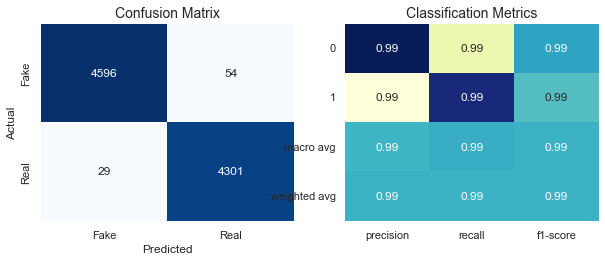

In [4]:
# Plot the above results
plt.figure(figsize=(10, 8))

# Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks([0.5, 1.5], ['Fake', 'Real'], fontsize=11)
plt.yticks([0.5, 1.5], ['Fake', 'Real'], fontsize=11)

# Classification Report Visualization
plt.subplot(2, 2, 2)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop('accuracy', axis=0)  # Remove accuracy row
report_df = report_df.drop('support', axis=1)  # Remove support column

# Plot the classification metrics
sns.heatmap(report_df, annot=True, cmap="YlGnBu", cbar=False, annot_kws={"size": 12})
plt.title('Classification Metrics', fontsize=14)

2.2 Feature importance with n-gram

In [5]:
# Feature importance with n-grams
print("\nAnalyzing feature importance with n-grams...")
ngram_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000, ngram_range=(2, 3))
X_ngram = ngram_vectorizer.fit_transform(df['clean_text'])

# Train/test split for n-gram model
X_train_ngram, X_test_ngram, y_train, y_test = train_test_split(X_ngram, y, test_size=0.2, random_state=42)

# Train model with n-grams
ngram_model = LogisticRegression(solver='lbfgs', max_iter=2000)
ngram_model.fit(X_train_ngram, y_train)

# Evaluate n-gram model
y_pred_ngram = ngram_model.predict(X_test_ngram)
acc_ngram = accuracy_score(y_test, y_pred_ngram)
print(f"N-gram Model Test Accuracy: {acc_ngram * 100:.2f}%")

# Extract feature importance
feature_names = ngram_vectorizer.get_feature_names()
coefs = ngram_model.coef_[0]

# Get top indices
top_fake_indices = np.argsort(coefs)[:20]
top_real_indices = np.argsort(coefs)[-20:]

print("\nTop phrases indicating FAKE news:")
for idx in top_fake_indices:
    print(f"{feature_names[idx]:<30}  coef: {coefs[idx]:.4f}")

print("\nTop phrases indicating REAL news:")
for idx in reversed(top_real_indices):
    print(f"{feature_names[idx]:<30}  coef: {coefs[idx]:.4f}")


Analyzing feature importance with n-grams...
N-gram Model Test Accuracy: 98.73%

Top phrases indicating FAKE news:
president trump                 coef: -7.6601
president obama                 coef: -7.0114
donald trump                    coef: -5.8989
hillary clinton                 coef: -4.7999
featured image                  coef: -4.2289
daily mail                      coef: -4.2173
getty images                    coef: -3.9013
fox news                        coef: -3.8182
breitbart news                  coef: -3.6722
century wire                    coef: -3.5540
screen capture                  coef: -3.5136
st century wire                 coef: -3.4862
st century                      coef: -3.4655
daily caller                    coef: -3.2137
don know                        coef: -3.1344
entire story                    coef: -3.1094
illegal aliens                  coef: -3.0716
obama administration            coef: -3.0689
gateway pundit                  coef: -2.7266
image flic

Text(0.5, 0, 'Absolute Coefficient Value')

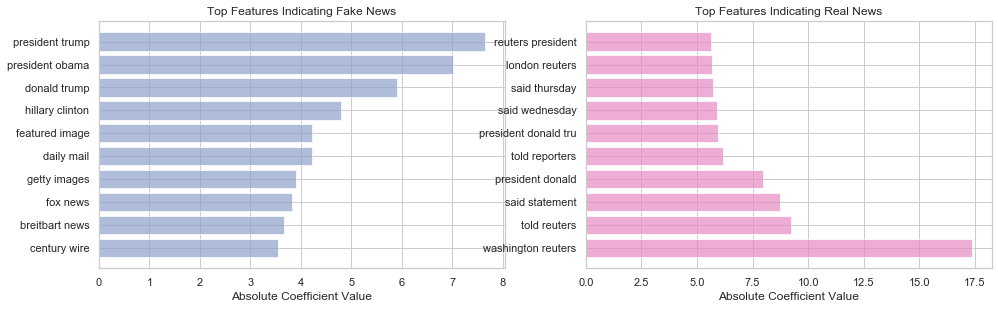

In [26]:
#Visualizing the above results
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 3)
fake_features = [feature_names[i] for i in top_fake_indices[:10]]  # Show top 10 for clarity
fake_importance = [abs(coefs[i]) for i in top_fake_indices[:10]]

y_pos = np.arange(len(fake_features))
plt.barh(y_pos, fake_importance, color=colors[2], alpha=0.7)
plt.yticks(y_pos, [f[:20] for f in fake_features])  # Truncate long feature names
plt.gca().invert_yaxis()  # Highest values at the top
plt.title('Top Features Indicating Fake News')
plt.xlabel('Absolute Coefficient Value')

# Feature Importance for Real News
plt.subplot(2, 2, 4)
real_features = [feature_names[i] for i in top_real_indices[-10:]]  # Show top 10 for clarity
real_importance = [abs(coefs[i]) for i in top_real_indices[-10:]]

y_pos = np.arange(len(real_features))
plt.barh(y_pos, real_importance, color=colors[3], alpha=0.7)
plt.yticks(y_pos, [f[:20] for f in real_features])  # Truncate long feature names
plt.gca().invert_yaxis()  # Highest values at the top
plt.title('Top Features Indicating Real News')
plt.xlabel('Absolute Coefficient Value')

2.3 Wordcloud for read and fake news

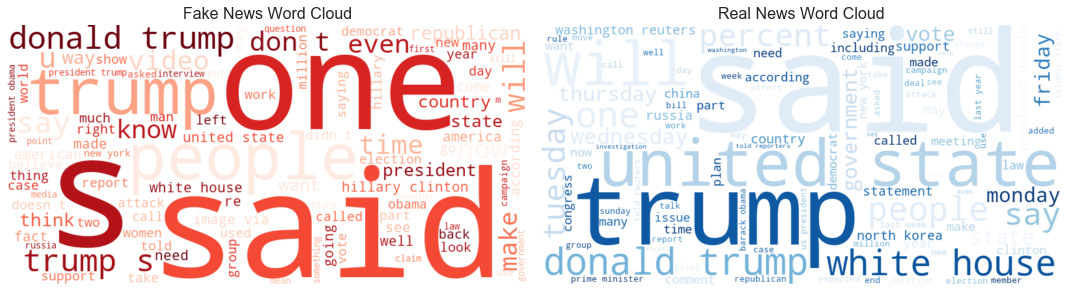

In [6]:
plt.figure(figsize=(15, 6))

# Get text for fake and real news
fake_text = " ".join(df[df['label'] == 0]['clean_text'].astype(str).tolist())
real_text = " ".join(df[df['label'] == 1]['clean_text'].astype(str).tolist())

# Create WordCloud for fake news
fake_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='Reds'
)
real_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='Blues'
)
fake_wordcloud = fake_wordcloud.generate(fake_text)
real_wordcloud = real_wordcloud.generate(real_text)

# plot
plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Real News Word Cloud', fontsize=16)

plt.tight_layout()
plt.show()

---

### 3. Program Optimization

#### 3.1 Using lecture 2 + lecture 3 optimization method

3.1.1

- using ''.join() instead of +=

- str += ch in a loop is O(n²) because strings are immutable.

- ''.join() builds the string in O(n) time — faster and more memory-efficient.

3.1.2
- using a cache dictionary to avoid re-cleaning duplicated text

- Memoization works before cleaning, so it's fast when raw text is duplicated but won’t help if 2 rows are semantically identical but textually different.


In [3]:

# Optimizer using ''.join() and cache
def optimized_clean_text(text):
    text = str(text).lower()
    return ''.join([ch for ch in text if ch.isalpha() or ch == ' '])

# Apply memoization to avoid duplicate cleaning
def memoized_apply_clean(df):
    cache = {}
    cleaned = []
    for t in df['text']:
        if t in cache:
            cleaned.append(cache[t])
        else:
            c = optimized_clean_text(t)
            cache[t] = c
            cleaned.append(c)
    df['clean_text'] = cleaned
    return df

# Start timing
start_time = time.time()

# Load and label data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
df_true['label'] = 1
df_fake['label'] = 0
df = pd.concat([df_true, df_fake], ignore_index=True)

# Combine title + text
df['text'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()

# Apply optimized cleaning
df = memoized_apply_clean(df)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(X_train, y_train)

# Accuracy
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# End timing
end_time = time.time()
execution_time = end_time - start_time
print(f"Optimized method 1 (built-in + memoization) finished in {execution_time:.4f} seconds.")
print(f"Speed improvement: {execution_time_baseline/execution_time:.2f}x faster than baseline")

track_performance("Join + Memoization", execution_time, acc)


Test Accuracy: 99.08%
Optimized method 1 (built-in + memoization) finished in 21.2608 seconds.
Speed improvement: 1.39x faster than baseline


---

#### 2.2 Replace clean_text with a Cython version

easy way to incorporate compiled C/C++ code in your Python programs
like mentioned in the lecture:

1. Not much gains in numerical programs since most of it is already in C

2. programs with loops: often large improvements

suitable for our baseline model here

In [4]:
import sys
!{sys.executable} setup.py build_ext --inplace


running build_ext
copying build/lib.macosx-10.9-x86_64-3.7/clean_text_cython.cpython-37m-darwin.so -> 


In [5]:
from clean_text_cython import clean_text as fast_clean_text

# Start timing
start_time = time.time()

# Load and label data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
df_true['label'] = 1
df_fake['label'] = 0
df = pd.concat([df_true, df_fake], ignore_index=True)

# Combine title + text
df['text'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()

# Clean using Cython text cleaner
df['clean_text'] = df['text'].apply(fast_clean_text)

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(X_train, y_train)

# Accuracy
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# End timing
end_time = time.time()
execution_time = end_time - start_time
print(f"Optimized method 2 with Cython finished in {execution_time:.4f} seconds.")
print(f"Speed improvement: {execution_time_baseline/execution_time:.2f}x faster than baseline")

track_performance("Cython", execution_time, acc)



Test Accuracy: 99.08%
Optimized method 2 with Cython finished in 21.9010 seconds.
Speed improvement: 1.35x faster than baseline


---

#### 2.3 Cython + Multiprocessing

2.3.1. Creates a pool of CPU workers equal to the number of available cores.

2.3.2. Distributes the fast_clean_text() function across multiple independent processes.


In [6]:

from multiprocessing import Pool, cpu_count

# Define multiprocessing
def parallel_clean_text(text_list):
    with Pool(cpu_count()) as pool:
        result = pool.map(fast_clean_text, text_list)
    return result

# Start timing
start_time = time.time()

# Load and label data
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
df_true['label'] = 1
df_fake['label'] = 0
df = pd.concat([df_true, df_fake], ignore_index=True)

# Combine title + text
df['text'] = (df['title'].fillna("") + " " + df['text'].fillna("")).str.strip()

# Apply multiprocessing
df['clean_text'] = parallel_clean_text(df['text'].tolist())

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'].values

# Split for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(X_train, y_train)

# Accuracy evaluation
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

# End timing
end_time = time.time()
execution_time = end_time - start_time
print(f"Optimized method 3 with multiprocessing finished in {execution_time:.4f} seconds.")
print(f"Speed improvement: {execution_time_baseline/execution_time:.2f}x faster than baseline")

track_performance("Cython + Multiprocessing", execution_time, acc)


Test Accuracy: 99.08%
Optimized method 3 with multiprocessing finished in 15.5302 seconds.
Speed improvement: 1.91x faster than baseline


----

### 4. Result Evaluation & Visualizations: Performance Optimization

#### 4.1 Performance optimization comparisons

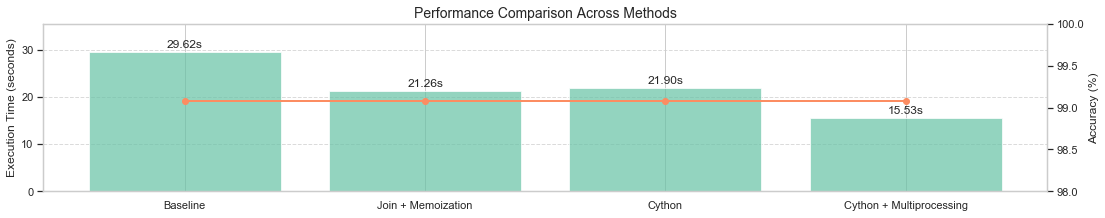

In [7]:
plt.figure(figsize=(18, 25))
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1.5, 1.5, 2])
ax1 = plt.subplot(gs[0, :])
bars = ax1.bar(performance_methods, performance_times, color=colors[0], alpha=0.7)

# Add accuracy on secondary axis
ax2 = ax1.twinx()
ax2.plot(performance_methods, [acc * 100 for acc in performance_accuracies], 'o-', color=colors[1], linewidth=2)
ax2.set_ylim([98, 100])  # Since accuracy is high, focus on minor differences
ax2.set_ylabel('Accuracy (%)')
ax2.grid(False)  # Turn off grid for second axis

# Add timing values on top of bars
for bar, time_val in zip(bars, performance_times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{time_val:.2f}s", ha='center', va='bottom')

ax1.set_title('Performance Comparison Across Methods', fontsize=14)
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_ylim(0, max(performance_times) * 1.2)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

#### 4.2 Speedup Comparison

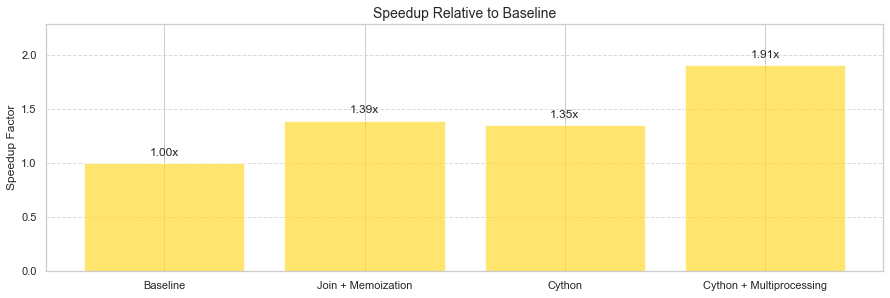

In [8]:
# Speedup comparison
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 2)
baseline_time = performance_times[0]  # First method is baseline
speedups = [baseline_time/time for time in performance_times]
speedup_bars = plt.bar(performance_methods, speedups, color=colors[5], alpha=0.7)

# Add speedup values on top of bars
for bar, speedup in zip(speedup_bars, speedups):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f"{speedup:.2f}x", ha='center', va='bottom')

plt.title('Speedup Relative to Baseline', fontsize=14)
plt.ylabel('Speedup Factor')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(speedups) * 1.2)

plt.show()